In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

slim = tf.contrib.slim
ds = tf.contrib.distributions

Populating the interactive namespace from numpy and matplotlib
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def grid_x(X):
    # [-1, 1] -> [0,255]
    if isinstance(X.flatten()[0], np.floating):
        X = ((X + 1.) * 127.5).astype('uint8')

    n_samples = X.shape[0]
    rows = int(np.sqrt(n_samples))
    while n_samples % rows != 0:
        rows -= 1

    nh, nw = rows, n_samples // rows

    if X.ndim == 2:
        X = np.reshape(X, (X.shape[0], int(np.sqrt(X.shape[1])), int(np.sqrt(X.shape[1]))))

    if X.ndim == 4:
        h, w = X[0].shape[:2]
        img = np.zeros((h * nh, w * nw, 3))
    elif X.ndim == 3:
        h, w = X[0].shape[:2]
        img = np.zeros((h * nh, w * nw))

    for n, x in enumerate(X):
        j = n // nw
        i = n % nw
        img[j * h:j * h + h, i * w:i * w + w] = x

    return img

In [3]:
def show_digits(digits_flatten):
    X = grid_x(digits_flatten.reshape([-1,28,28]))
    imshow(X,cmap='gray')
    axis('off')
    show()


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [36]:
def generator(z, output_dim=784, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=tf.nn.sigmoid)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

In [37]:
# def generator(z, output_dim=784, n_hidden=500, n_layer=4):
#     with tf.variable_scope("generator"):
#         x = tf.layers.dense(z,n_hidden,activation=tf.nn.relu)
#         x = tf.layers.dense(z,n_hidden)
#         x = tf.layers.dense(z,output_dim)
#     return x

# def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
#     with tf.variable_scope("discriminator", reuse=reuse):
#         x = tf.layers.dense(z,n_hidden,activation=tf.nn.relu)
#         x = tf.layers.dropout(x,0.5)
#         x = tf.layers.dense(z,n_hidden,activation=tf.nn.relu)
#         x = tf.layers.dropout(x,0.5)
#         x = tf.layers.dense(z,n_hidden,activation=tf.nn.relu)
#         x = tf.layers.dropout(x,0.5)
#         x = tf.layers.dense(z,n_hidden,activation=tf.nn.relu)
#         x = tf.layers.dropout(x,0.5)
#         x = tf.layers.dense(z,output_dim)
#     return log_d

### Data creation

In [38]:
def sample_mnist(batch_size):
    return mnist.train.next_batch(batch_size=batch_size)[0]

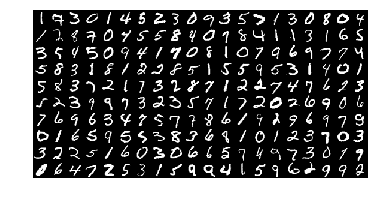

In [39]:
show_digits(sample_mnist(200))

### Hyperparam

In [40]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=8000,
    viz_every=1000,
    z_dim=256,
    x_dim=784,
    optimizer='rmsprop', # rmsprop sgd sga
)

## Function for Symplectic gradient adjustment

In [41]:
def jac_vec(ys,xs,vs):
    return fwd_gradients(ys,xs,grad_xs=vs, stop_gradients=xs)

def jac_tran_vec(ys,xs,vs):
    dydxs = tf.gradients(ys,xs,grad_ys=vs, stop_gradients=xs)
    return [tf.zeros_like(x) if dydx is None else dydx for (x,dydx) in zip(xs,dydxs)]

def get_sym_adj(Ls,xs):
    xi= [tf.gradients(l,x)[0]for(l,x)in zip(Ls,xs)]
    H_xi = jac_vec(xi,xs,xi)
    Ht_xi = jac_tran_vec(xi,xs,xi)
    At_xi =[(ht-h)/2 for (h,ht) in zip(H_xi,Ht_xi)]
    return At_xi

## Construct model and training ops

In [45]:
tf.reset_default_graph()

unl = tf.placeholder(tf.float32, [params['batch_size'], 784], name='unlabeled_data_input_pl')

data = sample_mnist(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(unl)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

loss_g = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.ones_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")        
    
if params['optimizer'] == 'sga': 
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
    gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)

    adj = get_sym_adj([loss]*len(disc_vars) + [-loss]*len(gen_vars),disc_vars+gen_vars)
    d_adj= adj[:len(disc_vars)]
    g_adj = adj[-len(gen_vars)::]
    
    dvs_sga = [(grad + adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + adj , var) for (grad,var),adj in zip(gvs,g_adj)]
    
    d_train_op = d_opt.apply_gradients(dvs_sga)
    g_train_op = g_opt.apply_gradients(gvs_sga)
    
if params['optimizer'] == 'rmsprop':
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(loss_g, var_list=gen_vars)    

## Train

In [46]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


  0%|          | 0/8001 [00:00<?, ?it/s]

Tensor("Mean:0", shape=(), dtype=float32)
(512, 784)


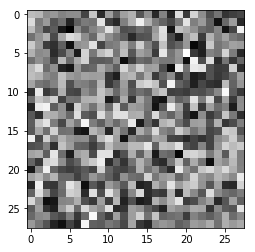


  6%|▌         | 495/8001 [00:06<01:36, 77.40it/s]

Tensor("Mean:0", shape=(), dtype=float32)
(512, 784)


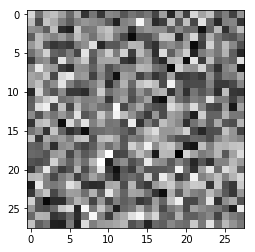


  8%|▊         | 652/8001 [00:08<01:34, 77.81it/s]
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/bruno/.local/lib/python3.5/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 12%|█▏        | 995/8001 [00:12<01:30, 77.08it/s]

Tensor("Mean:0", shape=(), dtype=float32)
(512, 784)


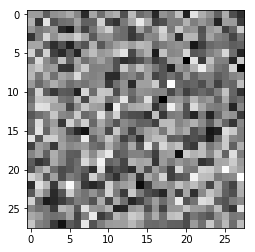

 19%|█▊        | 1491/8001 [00:19<01:23, 78.23it/s]


Tensor("Mean:0", shape=(), dtype=float32)
(512, 784)


KeyboardInterrupt: 

In [53]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
for i in tqdm(range(params['max_iter']+1)):
    f, _,_ = sess.run([loss, d_train_op, d_train_op],feed_dict={unl:sample_mnist(params['batch_size'])})

    fs.append(f)
    if (i) % viz_every == 0:
        print(loss)
        xx = sess.run(samples)
        print(xx.shape)
        imshow(xx[0,:].reshape([28,28]),cmap='gray')
        show()
#         show_digits(xx)

In [ ]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

In [ ]:
import seaborn as sns


In [20]:
28*28

784